# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import itemfreq
from mpl_toolkits.mplot3d import Axes3D
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
azdias_df = azdias.copy()

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
features_info_df = feat_info.copy()  
features_info_df.set_index('attribute', inplace=True)
features_info_df['columns'] = features_info_df.index

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias_df.shape)
print(list(azdias_df.columns.values))
azdias_df.describe()


(891221, 85)
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

def convert(string_list):
   
    missing_values_dict = {}
    conv = lambda x: x[1:-1].split(',')
    res = conv(string_list)
    
    for item in res:

        if item.replace('-','').isnumeric():
            missing_values_dict[int(item)] = np.nan
            
        if item.isalpha():
            missing_values_dict[str(item)] = np.nan
            
    
    return missing_values_dict



print(features_info_df.head(3))


missing_values = features_info_df[['columns','missing_or_unknown']].copy()
missing_values = missing_values.query('missing_or_unknown !="[]"')
missing_values['missing_or_unknown'] = missing_values['missing_or_unknown'].apply(convert)

missing_dict = {x[0]: x[1] for x in missing_values.itertuples(index=False)}
#missing_dict
missing_dict

for key,value in missing_dict.items():
    azdias_df[key].replace(value, inplace=True)

azdias_df.head(3)

                     information_level         type missing_or_unknown  \
attribute                                                                
AGER_TYP                        person  categorical             [-1,0]   
ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
ANREDE_KZ                       person  categorical             [-1,0]   

                                   columns  
attribute                                   
AGER_TYP                          AGER_TYP  
ALTERSKATEGORIE_GROB  ALTERSKATEGORIE_GROB  
ANREDE_KZ                        ANREDE_KZ  


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  

[3 rows x 85 columns]

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

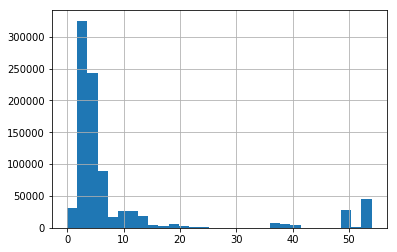

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_df.isnull().sum(axis=1).hist(bins=30)
na_counts_per_column = azdias_df.isnull().sum(axis=0).to_frame()
na_counts_per_column = na_counts_per_column.T.apply(lambda x: x / azdias_df.shape[0])

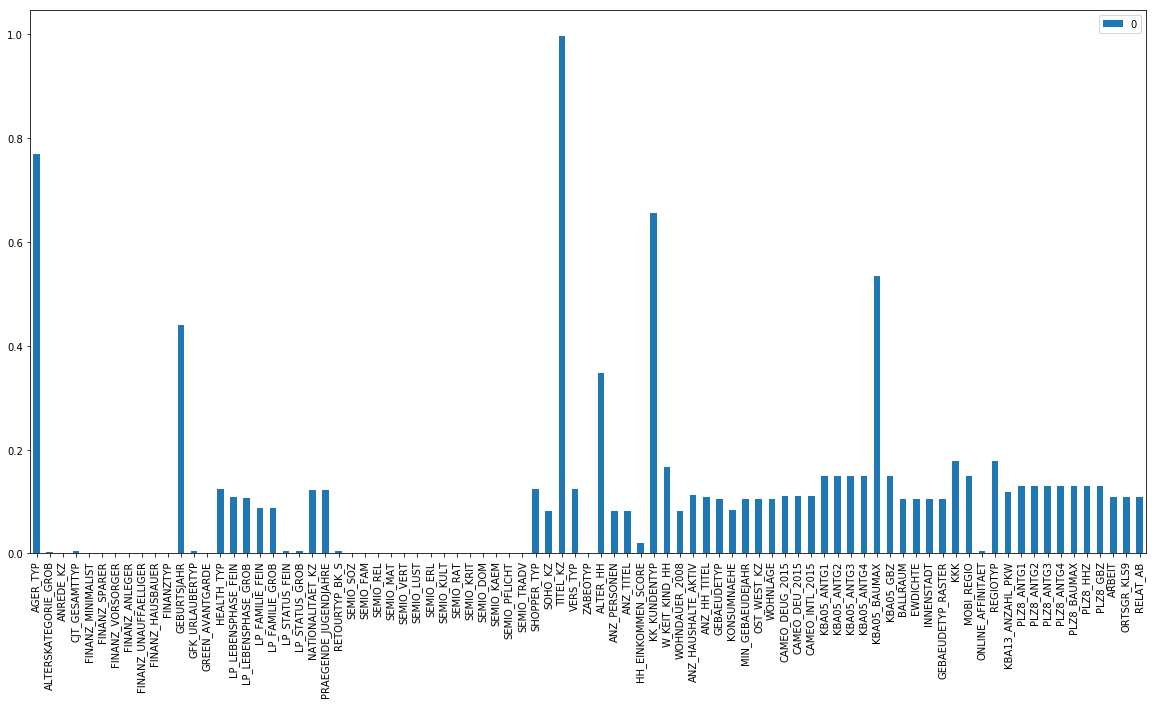

In [6]:
# Investigate patterns in the amount of missing data in each column.
na_counts_per_column.T.plot(kind='bar', figsize=(20,10))

In [7]:
# remove the columns that holds 20% and more of missing data

missing_20 = [col for col in azdias_df.columns if (azdias_df[col].isnull().sum()/azdias.shape[0]) * 100 > 20]
print(missing_20)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


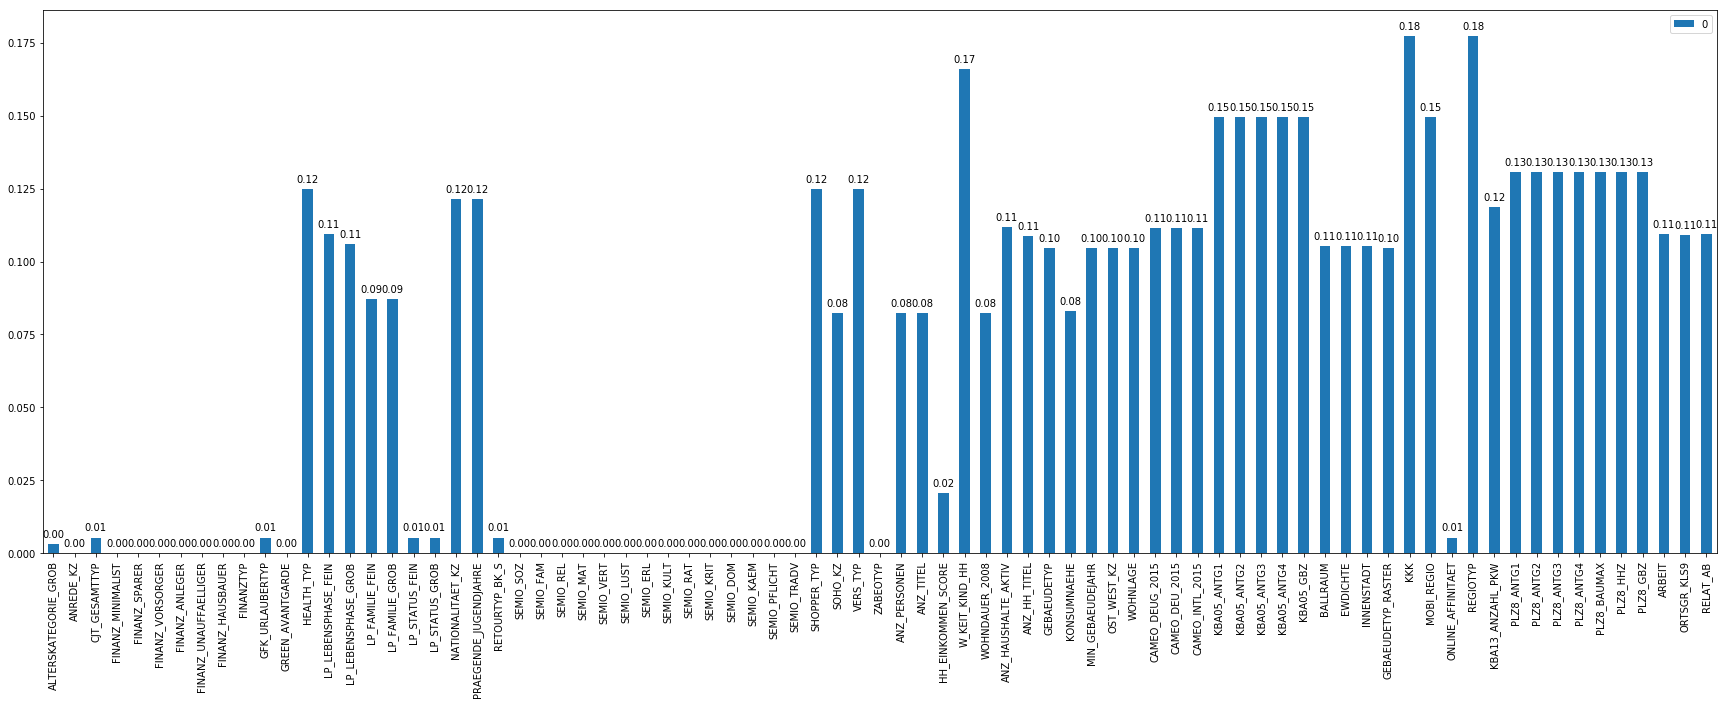

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

for col in missing_20:
    azdias_df.drop(col, axis=1, inplace=True)

na_counts_per_column_new = azdias_df.isnull().sum(axis=0).to_frame()
na_counts_per_column_new = na_counts_per_column_new.T.apply(lambda x: x / azdias_df.shape[0])
    
ax = na_counts_per_column_new.T.plot(kind='bar', figsize=(30,10))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


#### Discussion 1.1.2: Assess Missing Data in Each Column

based on above graphs we could conclude the following
1. some columns has high coorelation such as **KBA05** related columns and **PLZ8** related columns, as the ratios of missing data in their related columns are the same 

2. in total 6 columns have been removed as listed below
    * AGER_TYP
    * GEBURTSJAHR
    * TITEL_KZ
    * KK_KUNDENTYP
    * KBA05_BAUMAX
    * ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

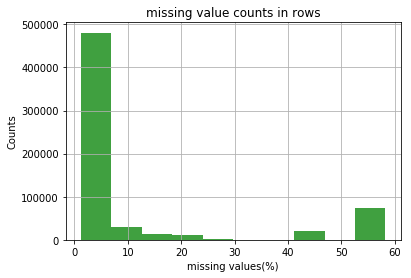

In [9]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias.isnull().sum(axis=1)
missing_in_row = missing_in_row[missing_in_row > 0]/(len(azdias_df.columns)) * 100

plt.hist(missing_in_row, bins=10, facecolor='g', alpha=0.75)


plt.xlabel('missing values(%)')
plt.ylabel('Counts')
plt.title('missing value counts in rows')
plt.grid(True)
plt.show()

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


missing_data_le_2 = azdias_df[azdias_df.isnull().sum(axis=1) < 2].reset_index(drop=True)
missing_data_gt_2 = azdias_df[azdias_df.isnull().sum(axis=1) >= 2].reset_index(drop=True)

print(missing_data_le_2.shape)
missing_data_gt_2.head(3)

(638947, 79)


ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   4.0          2            2.0                  4   
2                   2.0          1            6.0                  3   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              2                 5               2                      1   
2              4                 3               5                      5   

   FINANZ_HAUSBAUER  FINANZTYP    ...     PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 3          4    ...            NaN         NaN         NaN   
1                 2          6    ...            2.0         2.0         2.0   
2                 3          4    ...            NaN         NaN         NaN   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0         NaN          NaN       NaN       NaN     NaN          NaN       NaN  
1         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
2         NaN          NaN       NaN       NaN     NaN          NaN       NaN  

[3 rows x 79 columns]

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


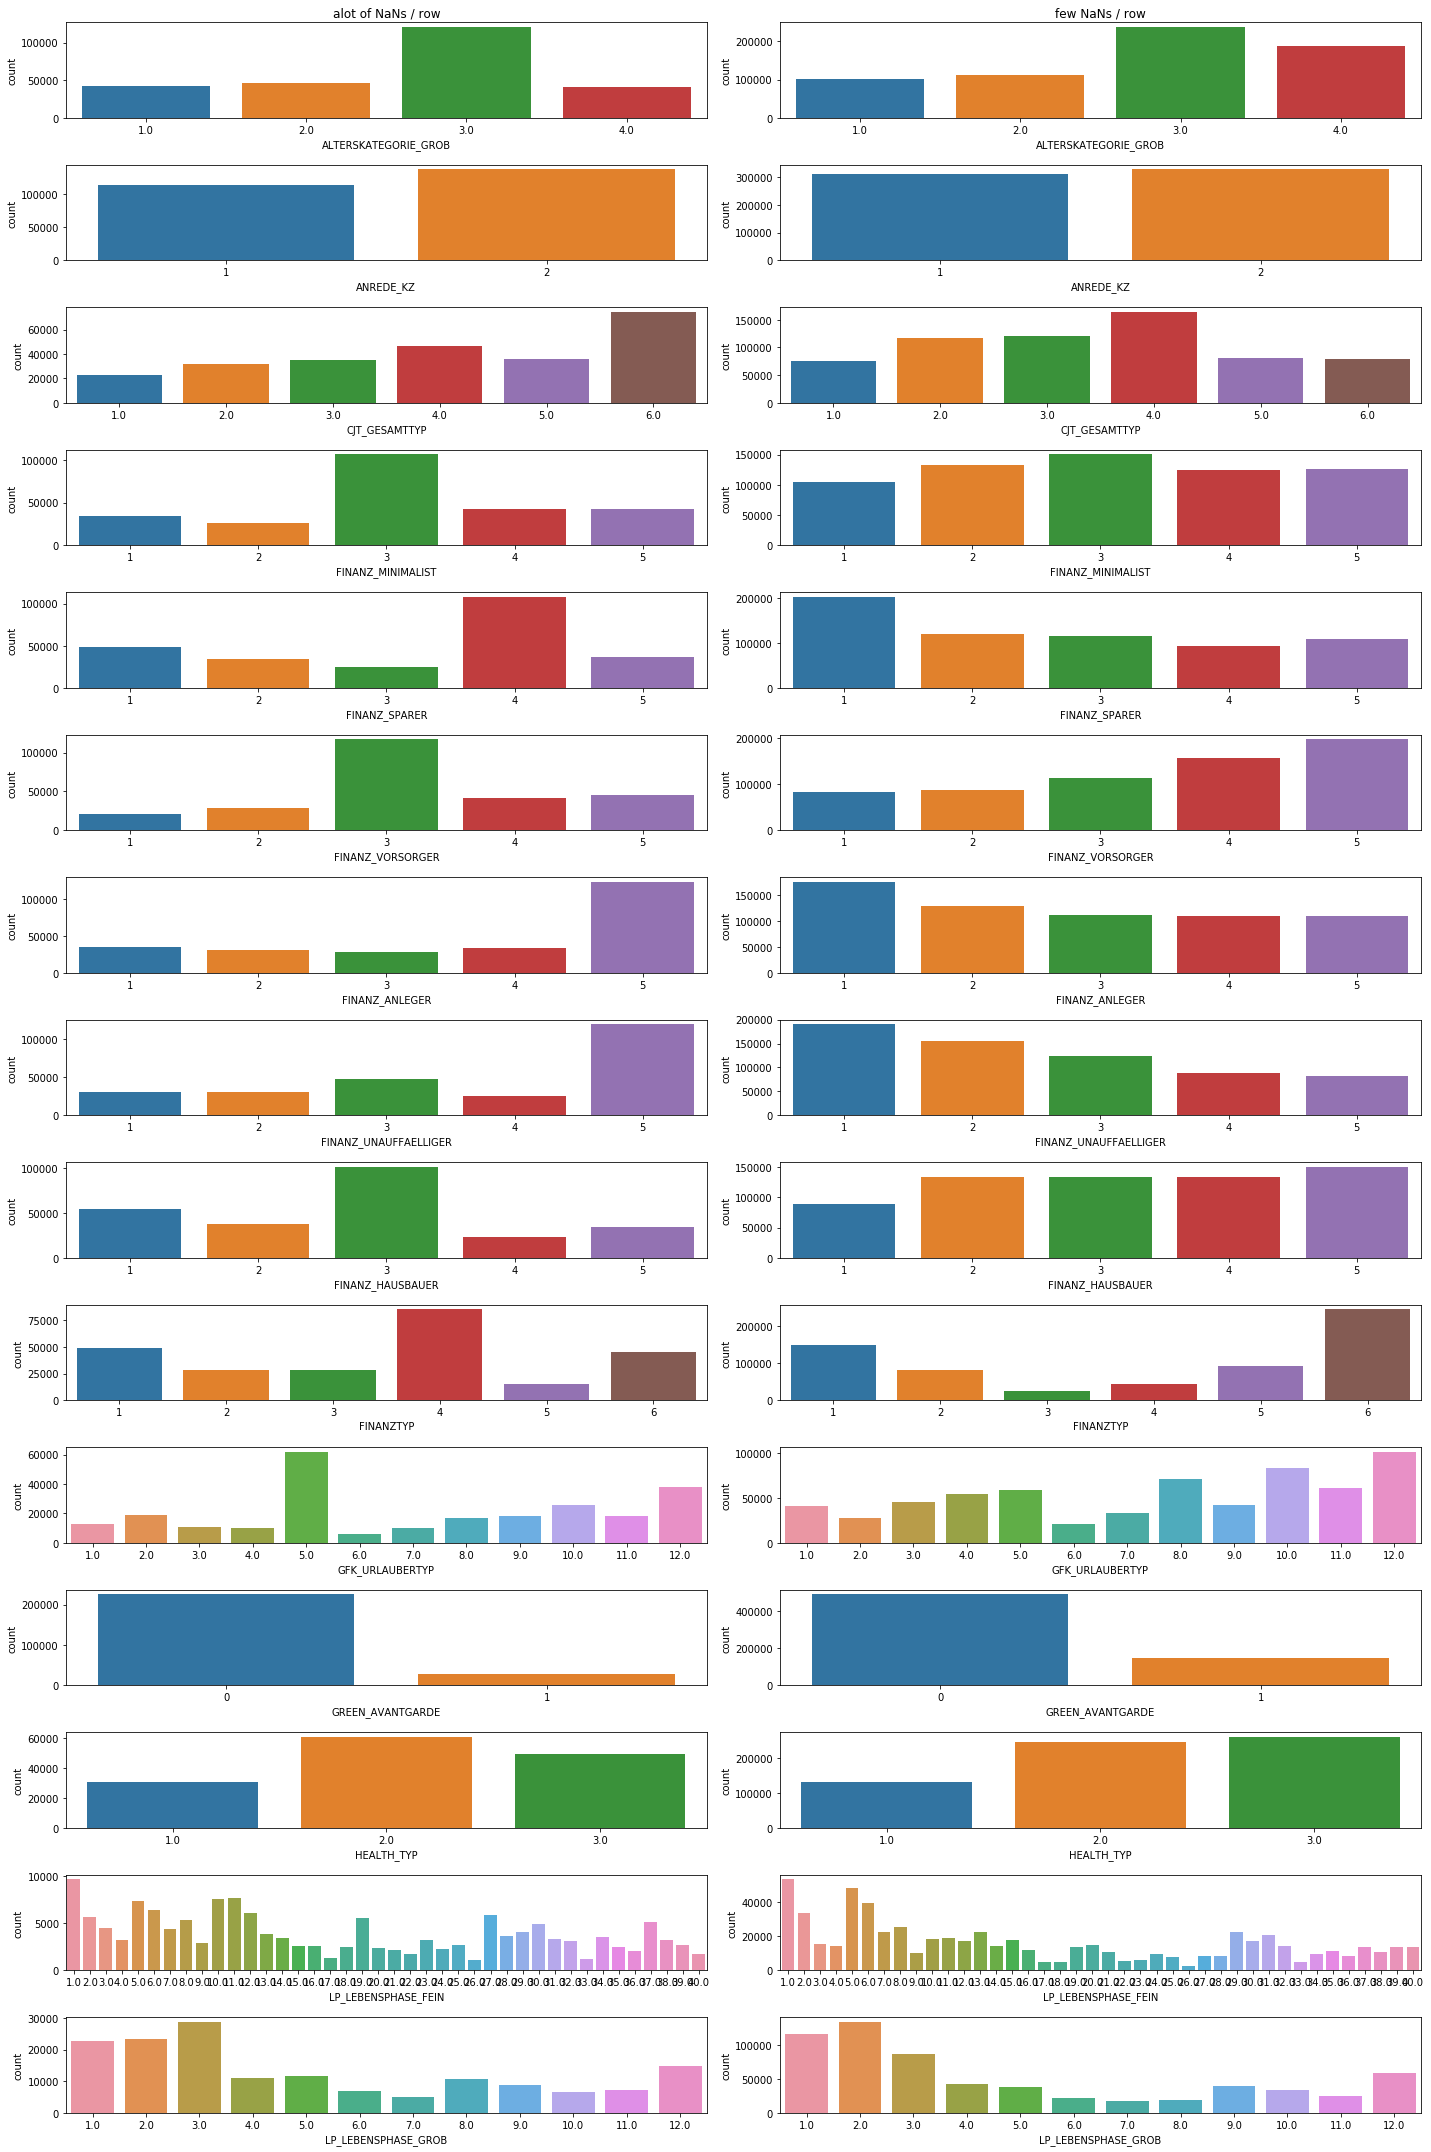

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

row = 15 
col = 2 
fig, ax =plt.subplots(nrows=row, ncols=col, figsize = (20,30))
index = 0

if index < 15: 
    for i in range(row): 
        sns.countplot(x=missing_data_gt_2.columns[index],data=missing_data_gt_2, ax=ax[i][0])
        sns.countplot(x=missing_data_le_2.columns[index],data=missing_data_le_2, ax=ax[i][1])

        index = index + 1
    
ax[0][0].set_title('alot of NaNs / row') 
ax[0][1].set_title('few NaNs / row') 
fig.tight_layout() 
fig.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Looking at avarages of missing data per row, it seems  that most rows have around 5%. I set the threshold to 2 missing values in each row, knowing that we are going to loose a lot of data but the remaining data is cleaner

1. It seems that the populations are pretty similar in age and gender, Life stage, , but are pretty different when it comes to financial spending patterns
2. the data is qualitatively different when it comes to finance, Vacation habits, and preferred information and buying channels for consumer

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?

types={}
for col in missing_data_le_2.columns:
    data_type = features_info_df.loc[col].type
    if data_type not in types:
        types[data_type] = 1
    else:
        types[data_type] += 1

print(types)

{'ordinal': 49, 'categorical': 18, 'mixed': 6, 'numeric': 6}


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

bin_list = [] 
multi_level_list = [] 

filtered_features = features_info_df.loc[missing_data_le_2.columns]

cat_variable = missing_data_le_2[filtered_features[filtered_features['type'] == 'categorical']['columns']] 
cat_variable

for t in cat_variable: 
    if len(cat_variable[t].value_counts()) == 2 and  (
        set(cat_variable[t]) & set([0, 1]) == set([0, 1]) or 
        set(cat_variable[t]) & set([0.0, 1.0]) == set([0.0, 1.0])
    ): 
        bin_list.append(t) 
    else: 
        multi_level_list.append(t)


print(cat_variable.info())
print('-'*50)
pprint('Binary: {}'.format(bin_list))
print('')
pprint('multi-level: {}'.format(multi_level_list))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638947 entries, 0 to 638946
Data columns (total 18 columns):
ANREDE_KZ           638947 non-null int64
CJT_GESAMTTYP       638947 non-null float64
FINANZTYP           638947 non-null int64
GFK_URLAUBERTYP     638947 non-null float64
GREEN_AVANTGARDE    638947 non-null int64
LP_FAMILIE_FEIN     638947 non-null float64
LP_FAMILIE_GROB     638947 non-null float64
LP_STATUS_FEIN      638947 non-null float64
LP_STATUS_GROB      638947 non-null float64
NATIONALITAET_KZ    638947 non-null float64
SHOPPER_TYP         638947 non-null float64
SOHO_KZ             638947 non-null float64
VERS_TYP            638947 non-null float64
ZABEOTYP            638947 non-null int64
GEBAEUDETYP         638947 non-null float64
OST_WEST_KZ         638947 non-null object
CAMEO_DEUG_2015     638947 non-null object
CAMEO_DEU_2015      638947 non-null object
dtypes: float64(11), int64(4), object(3)
memory usage: 87.7+ MB
None
---------------------------------------

In [14]:
missing_data_le_2[['GREEN_AVANTGARDE','SOHO_KZ','ANREDE_KZ']].T

0       1       2       3       4       5       6       \
GREEN_AVANTGARDE     0.0     1.0     0.0     0.0     0.0     0.0     1.0   
SOHO_KZ              1.0     0.0     0.0     0.0     0.0     0.0     0.0   
ANREDE_KZ            2.0     2.0     1.0     2.0     2.0     1.0     1.0   

                  7       8       9        ...    638937  638938  638939  \
GREEN_AVANTGARDE     1.0     0.0     1.0   ...       1.0     0.0     0.0   
SOHO_KZ              0.0     0.0     0.0   ...       0.0     0.0     0.0   
ANREDE_KZ            2.0     2.0     1.0   ...       2.0     2.0     1.0   

                  638940  638941  638942  638943  638944  638945  638946  
GREEN_AVANTGARDE     0.0     0.0     1.0     0.0     0.0     0.0     0.0  
SOHO_KZ              0.0     0.0     0.0     0.0     0.0     0.0     0.0  
ANREDE_KZ            1.0     1.0     2.0     2.0     2.0     1.0     1.0  

[3 rows x 638947 columns]

In [15]:
# Re-encode categorical variable(s) to be kept in the analysis.

# encode binary
df_with_dummies = pd.get_dummies( missing_data_le_2, columns = bin_list ,drop_first=True)
# drop multi-level
for col in multi_level_list:
    df_with_dummies.drop(col, axis=1, inplace=True)

print(df_with_dummies.columns.tolist())

df_with_dummies.shape


['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'GREEN_AVANTGARDE_1', 'SOHO

(638947, 63)

#### Discussion 1.2.1: Re-Encode Categorical Features

1. garph the variability in the dataset as it could indicate categorical results, on the other hand it helps to visualize the categories
2. split the categorical columns between binary(2 values "0/1 , 0.0, 1.0"), and multi-level (> 2 values) based on AZDIAS_Feature_Summary.csv file
3. refered back to Data_Dictionary.md and the categories garph above to check the values
4. decided with dropping all the multi-level features
5. i used get_dummies for encoding with dropping the first accurance

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [16]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
first_var_dict = {
    -1:{'period': np.nan, 'direction': np.nan},
    0:{'period': np.nan, 'direction': np.nan},
    1: {'period': 40, 'direction': 'EW'},
    2: {'period': 40, 'direction': 'EW'},
    3: {'period': 50, 'direction': 'EW'},
    4: {'period': 50, 'direction': 'EW'},
    5: {'period': 60, 'direction': 'EW'},
    6: {'period': 60, 'direction': 'W'},
    7: {'period': 60, 'direction': 'E'},
    8: {'period': 70, 'direction': 'EW'},
    9: {'period': 70, 'direction': 'EW'},
    10: {'period': 80, 'direction': 'W'},
    11: {'period': 80, 'direction': 'W'},
    12: {'period': 80, 'direction': 'E'},
    13: {'period': 80, 'direction': 'E'},
    14: {'period': 90, 'direction': 'EW'},
    15: {'period': 90, 'direction': 'EW'}
}

#initialize two columns
df_with_dummies['PRAEGENDE_JUGENDJAHRE_PERIOD']= 0
df_with_dummies['PRAEGENDE_JUGENDJAHRE_DIRECTION'] = 'x'


for key, values in first_var_dict.items():
    #df_with_dummies[['PRAEGENDE_JUGENDJAHRE_PERIOD','PRAEGENDE_JUGENDJAHRE_DIRECTION']] = 
    row_indexes = df_with_dummies[df_with_dummies['PRAEGENDE_JUGENDJAHRE'] == key].index
    df_with_dummies.loc[row_indexes,'PRAEGENDE_JUGENDJAHRE_PERIOD']= values['period']
    df_with_dummies.loc[row_indexes,'PRAEGENDE_JUGENDJAHRE_DIRECTION']= values['direction']

# check missing
print(f'missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]: ', df_with_dummies[df_with_dummies['PRAEGENDE_JUGENDJAHRE_PERIOD'] == 0].shape[0])
print('missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]: ', df_with_dummies[df_with_dummies['PRAEGENDE_JUGENDJAHRE_DIRECTION'] == 'x'].shape[0])

# drop the original column
df_with_dummies.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

#create dummy for direction
df_with_dummies = pd.get_dummies( df_with_dummies, columns = ['PRAEGENDE_JUGENDJAHRE_DIRECTION'] ,drop_first=True)



missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]:  6226
missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]:  6226


In [17]:
df_with_dummies['CAMEO_INTL_2015'].value_counts(dropna=False)

51    114736
41     76608
24     75385
14     49195
43     47588
54     39345
25     31483
22     24326
45     22420
55     20049
13     19922
52     17097
34     15529
23     14926
15     13752
31     12673
44     12419
35      8631
32      8287
33      7575
12      7001
Name: CAMEO_INTL_2015, dtype: int64

In [18]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#  convert the type of CAMEO_INTL_2015 from int to integer
#df_with_dummies['CAMEO_INTL_2015'] = df_with_dummies['CAMEO_INTL_2015'].astype(int)

#initialize columns

def get_life_stage(number):
    if number == '-1' or number == 'XX':
        return np.nan
    return int(number) % 10

def get_wealth(number):
    if number == '-1' or number == 'XX':
        return np.nan
    
    number = int(number) //10
    return number % 10

df_with_dummies['CAMEO_INTL_2015_WEALTH'] = df_with_dummies['CAMEO_INTL_2015'].apply(get_wealth)
df_with_dummies['CAMEO_INTL_2015_LIFE_STAGE'] = df_with_dummies['CAMEO_INTL_2015'].apply(get_life_stage)

print(df_with_dummies[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']].head(10).T)

df_with_dummies.drop('CAMEO_INTL_2015', axis=1, inplace=True)

                             0   1   2   3   4   5   6   7   8   9
CAMEO_INTL_2015             51  24  43  54  22  14  13  15  51  34
CAMEO_INTL_2015_WEALTH       5   2   4   5   2   1   1   1   5   3
CAMEO_INTL_2015_LIFE_STAGE   1   4   3   4   2   4   3   5   1   4


In [19]:
# drop the remaining mixed categories

mixed_features_df = features_info_df.loc[missing_data_le_2.columns][['columns','type']].query('type == "mixed"')

columns = set(mixed_features_df['columns'].tolist())
columns = columns - set(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'])

pprint(f'columns that will be dropped: {columns}')

df_with_dummies.drop(columns, axis=1, inplace=True)


# check if columns still there
columns in set(df_with_dummies.columns)

("columns that will be dropped: {'WOHNLAGE', 'PLZ8_BAUMAX', "
 "'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'}")


False

In [20]:
df_with_dummies.shape

(638947, 63)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. i dropped all mixed features other than the two features that have been engineered in the privious steps
2. engineering steps for **PRAEGENDE_JUGENDJAHRE**:
    * create a dictionary for the values to be inserted in the generated features
    * initialize the new featires in the dataframe
    * loop over the dictionary keys/values where the key in the dict = the value in the feature that we want to process
    * extract the indecies for the rows that mathes the values, and append proper values for the new 2 features base on the dict values 
    * drop the original column
3. engineering steps for **CAMEO_INTL_2015**
    * create to functions to extract features values from the original feature
    * apply those two functions to the original feature to fill the new features
4. dropped features
    * extract the mixed features from feat_info
    * get the columns and convert them to set
    * subtract the two columns that we already processed in the previous steps
    * drop the remaining columns


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [21]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

features = feat_info[['attribute','type']]
columns = features['attribute'].tolist()

dict_of_remaining_cols = {}

for col in columns:
    if col in df_with_dummies or df_with_dummies.columns.str.startswith(col).any():
        df_columns = df_with_dummies.filter(regex=f'{col}.*').columns.tolist()
        dict_of_remaining_cols[col] = { 
            'category' :features[features['attribute'] == col ].iloc[0][1],
            'columns': df_columns
        }

pprint(f'size of the featires {df_with_dummies.shape[1]}')
print('-'*50)
pprint(dict_of_remaining_cols)

pprint(dict_of_remaining_cols.keys())


'size of the featires 63'
--------------------------------------------------
{'ALTERSKATEGORIE_GROB': {'category': 'ordinal',
                          'columns': ['ALTERSKATEGORIE_GROB']},
 'ANZ_HAUSHALTE_AKTIV': {'category': 'numeric',
                         'columns': ['ANZ_HAUSHALTE_AKTIV']},
 'ANZ_HH_TITEL': {'category': 'numeric', 'columns': ['ANZ_HH_TITEL']},
 'ANZ_PERSONEN': {'category': 'numeric', 'columns': ['ANZ_PERSONEN']},
 'ANZ_TITEL': {'category': 'numeric', 'columns': ['ANZ_TITEL']},
 'ARBEIT': {'category': 'ordinal', 'columns': ['ARBEIT']},
 'BALLRAUM': {'category': 'ordinal', 'columns': ['BALLRAUM']},
 'CAMEO_INTL_2015': {'category': 'mixed',
                     'columns': ['CAMEO_INTL_2015_WEALTH',
                                 'CAMEO_INTL_2015_LIFE_STAGE']},
 'EWDICHTE': {'category': 'ordinal', 'columns': ['EWDICHTE']},
 'FINANZ_ANLEGER': {'category': 'ordinal', 'columns': ['FINANZ_ANLEGER']},
 'FINANZ_HAUSBAUER': {'category': 'ordinal', 'columns': ['FINANZ_HA

In [22]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# remove the columns that has been agreed on in section 1.1.2 if they still exist 
# GEBURTSJAHR, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX, ALTER_HH but before check if they are ordinal or interval
cols = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','ALTER_HH']

for c in cols:
    if c in dict_of_remaining_cols.keys() and dict_of_remaining_cols[c]['category']== 'categorical':
        df_with_dummies.drop(dict_of_remaining_cols[c]['columns'], axis=1, inplace=True)
        print(f'dropping: {dict_of_remaining_cols[c]["columns"]}')
        
    
df_with_dummies.shape

(638947, 63)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [23]:
# convert string list to related list of numerics or strings based
import math
def convert(string_list):
   
    missing_values_dict = {}
    conv = lambda x: x[1:-1].split(',')
    res = conv(string_list)
    
    for item in res:

        if item.replace('-','').isnumeric():
            missing_values_dict[int(item)] = np.nan
            
        if item.isalpha():
            missing_values_dict[str(item)] = np.nan
            
    return missing_values_dict

# related to extract life_stage feature from CAMEO_INTL_2015
def get_life_stage(number):
    if number == '-1' or number == 'XX' or math.isnan(float(number)):
        return np.nan
    return int(number) % 10

# related to extract wealth feature from CAMEO_INTL_2015
def get_wealth(number):
    if number == '-1' or number == 'XX' or math.isnan(float(number)):
        return np.nan
    
    number = int(number) //10
    return number % 10

# extract missing features values from feature_info and construct a dictionary from the values
def get_missing_features_dict_from_features_info(features_info_df):
    missing_values = features_info_df[['attribute','missing_or_unknown']].copy()
    missing_values = missing_values.query('missing_or_unknown !="[]"')
    missing_values['missing_or_unknown'] = missing_values['missing_or_unknown'].apply(convert)
    
    missing_dict = {x[0]: x[1] for x in missing_values.itertuples(index=False)}
    
    return missing_dict

def create_binary_multi_level_features_list(data, features_info_df):
    bin_list = [] 
    multi_level_list = [] 
    available_features = []
    cat_features = features_info_df[features_info_df['type'] == 'categorical']['attribute'].tolist()
    
    for f in cat_features:
        if f in data:
            available_features.append(f)
    
    cat_variable = data[available_features]
    
    for t in available_features: 
        if len(cat_variable[t].value_counts()) == 2 and  (
            set(cat_variable[t]) & set([0, 1]) == set([0, 1]) or 
            set(cat_variable[t]) & set([0.0, 1.0]) == set([0.0, 1.0])
        ): 
            bin_list.append(t) 
        else: 
            multi_level_list.append(t)
    
    return bin_list, multi_level_list

In [24]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    available_features = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    missing_features_dict = get_missing_features_dict_from_features_info(available_features)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for key,value in missing_features_dict.items():
        df[key].replace(value, inplace=True)
    
    # remove selected columns and rows, ...
    
    #remove columns
    columns_to_be_dropped = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','ALTER_HH', 
                             'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX','LP_LEBENSPHASE_FEIN', 'WOHNLAGE']
    
    df.drop(columns_to_be_dropped, axis=1, inplace=True)
    
    #drop every row has more that 2 NaNs
    df = df[df.isnull().sum(axis=1) < 2].reset_index(drop=True)
    
    # get binary/ multilevel features lists
    binary_features_list, multilevel_features_list =  create_binary_multi_level_features_list(df, available_features)
    
    #encode features for binary_features_list
    df= pd.get_dummies( df, columns = binary_features_list ,drop_first=True)
        
    # drop multi-level
    for col in multi_level_list:
        df.drop(col, axis=1, inplace=True)
        
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(get_wealth)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(get_life_stage)

    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    first_var_dict = {
        -1:{'period': np.nan, 'direction': np.nan},
        0:{'period': np.nan, 'direction': np.nan},
        1: {'period': 40, 'direction': 'EW'},
        2: {'period': 40, 'direction': 'EW'},
        3: {'period': 50, 'direction': 'EW'},
        4: {'period': 50, 'direction': 'EW'},
        5: {'period': 60, 'direction': 'EW'},
        6: {'period': 60, 'direction': 'W'},
        7: {'period': 60, 'direction': 'E'},
        8: {'period': 70, 'direction': 'EW'},
        9: {'period': 70, 'direction': 'EW'},
        10: {'period': 80, 'direction': 'W'},
        11: {'period': 80, 'direction': 'W'},
        12: {'period': 80, 'direction': 'E'},
        13: {'period': 80, 'direction': 'E'},
        14: {'period': 90, 'direction': 'EW'},
        15: {'period': 90, 'direction': 'EW'}
    }

    #initialize two columns
    df['PRAEGENDE_JUGENDJAHRE_PERIOD']= 0
    df['PRAEGENDE_JUGENDJAHRE_DIRECTION'] = 'x'


    for key, values in first_var_dict.items():
        row_indexes = df[df['PRAEGENDE_JUGENDJAHRE'] == key].index
        df.loc[row_indexes,'PRAEGENDE_JUGENDJAHRE_PERIOD']= values['period']
        df.loc[row_indexes,'PRAEGENDE_JUGENDJAHRE_DIRECTION']= values['direction']

    # check missing
    print(f'missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]: ', df[df['PRAEGENDE_JUGENDJAHRE_PERIOD'] == 0].shape[0])
    print('missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]: ', df[df['PRAEGENDE_JUGENDJAHRE_DIRECTION'] == 'x'].shape[0])

    # drop the original column
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    #create dummy from direction
    df = pd.get_dummies( df, columns = ['PRAEGENDE_JUGENDJAHRE_DIRECTION'] ,drop_first=True)
    
    
    # final validation 
    #check if columns still there column to be dropped
    
    mixed_features_df = available_features.query('type == "mixed"')[['attribute','type']]

    columns = set(mixed_features_df['attribute'].tolist())
    columns = columns  - set(columns_to_be_dropped) - set(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'])

    df.drop(columns, axis=1, inplace=True)
    
    columns in set(df.columns)

    features = available_features[['attribute','type']]
    columns = features['attribute'].tolist()

    dict_of_remaining_cols = {}

    for col in columns:
        if col in df or df.columns.str.startswith(col).any():
            df_columns = df.filter(regex=f'{col}.*').columns.tolist()
            dict_of_remaining_cols[col] = { 
                'category' :features[features['attribute'] == col ].iloc[0][1],
                'columns': df_columns
            }

    for c in columns_to_be_dropped:
        if c in dict_of_remaining_cols.keys() and dict_of_remaining_cols[c]['category']== 'categorical':
            df.drop(dict_of_remaining_cols[c]['columns'], axis=1, inplace=True)
    
    
    #df['GEBAEUDETYP_5.0'].value_counts()
    # drop the below column because 
    #0.0    697108
    #1.0         1
    #Name: GEBAEUDETYP_5.0, dtype: int64
    # and this column doesnt exist after cleanup the clustomer data 
    if 'GEBAEUDETYP_5.0' in df.columns:
        df.drop(['GEBAEUDETYP_5.0'], axis=1, inplace=True) 
    
    # Return the cleaned dataframe.
    return df
    

In [25]:
clean_df = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';'))
clean_df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]:  6226
missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]:  6226


(638948, 63)

In [26]:
set(clean_df.columns.tolist()) - set(df_with_dummies.columns.tolist())

set()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [27]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

clean_df = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';'))
#clean_df.dropna(axis=0, how='any', inplace=True)

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputed_df = pd.DataFrame(fill_NaN.fit_transform(clean_df))
imputed_df.columns = clean_df.columns
imputed_df.index = clean_df.index
imputed_df.head()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]:  6226
missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]:  6226


ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                   1.0                1.0            5.0               2.0   
1                   3.0                1.0            4.0               1.0   
2                   3.0                4.0            3.0               4.0   
3                   1.0                3.0            1.0               5.0   
4                   2.0                1.0            5.0               1.0   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0             5.0                    4.0               5.0         3.0   
1             2.0                    3.0               5.0         3.0   
2             1.0                    3.0               2.0         3.0   
3             2.0                    2.0               5.0         3.0   
4             5.0                    4.0               3.0         2.0   

   RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0             1.0        5.0                ...                          5.0   
1             3.0        4.0                ...                          5.0   
2             5.0        6.0                ...                          6.0   
3             3.0        2.0                ...                          3.0   
4             4.0        2.0                ...                          6.0   

   RELAT_AB  GREEN_AVANTGARDE_1  SOHO_KZ_1.0  CAMEO_INTL_2015_WEALTH  \
0       4.0                 0.0          1.0                     5.0   
1       2.0                 1.0          0.0                     2.0   
2       5.0                 0.0          0.0                     4.0   
3       3.0                 0.0          0.0                     5.0   
4       3.0                 0.0          0.0                     2.0   

   CAMEO_INTL_2015_LIFE_STAGE  PRAEGENDE_JUGENDJAHRE_PERIOD  \
0                         1.0                          90.0   
1                         4.0                          90.0   
2                         3.0                          70.0   
3                         4.0                          50.0   
4                         2.0                          80.0   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_EW  PRAEGENDE_JUGENDJAHRE_DIRECTION_W  \
0                                 1.0                                0.0   
1                                 1.0                                0.0   
2                                 1.0                                0.0   
3                                 1.0                                0.0   
4                                 0.0                                1.0   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_x  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  

[5 rows x 63 columns]

In [28]:
# Apply feature scaling to the general population demographics data.

normalizer = StandardScaler()
imputed_df[imputed_df.columns] = normalizer.fit_transform(imputed_df[imputed_df.columns].as_matrix())
imputed_df.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0             -1.746615          -1.509100       1.580890         -1.052777   
1              0.193101          -1.509100       0.902594         -1.772865   
2              0.193101           0.697487       0.224298          0.387398   
3             -1.746615          -0.038042      -1.132295          1.107486   
4             -0.776757          -1.509100       1.580890         -1.772865   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0        1.537350               1.049674          1.321729    1.053060   
1       -0.526091               0.321756          1.321729    1.053060   
2       -1.213905               0.321756         -0.869497    1.053060   
3       -0.526091              -0.406161          1.321729    1.053060   
4        1.537350               1.049674         -0.139088   -0.267127   

   RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0       -1.665180   0.391691                ...                    -0.173454   
1       -0.292609  -0.120026                ...                    -0.173454   
2        1.079962   0.903408                ...                     0.262148   
3       -0.292609  -1.143461                ...                    -1.044659   
4        0.393676  -1.143461                ...                     0.262148   

   RELAT_AB  GREEN_AVANTGARDE_1  SOHO_KZ_1.0  CAMEO_INTL_2015_WEALTH  \
0  0.654923           -0.549006    10.821506                1.140899   
1 -0.826003            1.821475    -0.092409               -0.917834   
2  1.395386           -0.549006    -0.092409                0.454655   
3 -0.085540           -0.549006    -0.092409                1.140899   
4 -0.085540           -0.549006    -0.092409               -0.917834   

   CAMEO_INTL_2015_LIFE_STAGE  PRAEGENDE_JUGENDJAHRE_PERIOD  \
0                   -1.248658                      1.087458   
1                    0.749749                      1.087458   
2                    0.083614                     -0.150397   
3                    0.749749                     -1.388253   
4                   -0.582522                      0.468531   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_EW  PRAEGENDE_JUGENDJAHRE_DIRECTION_W  \
0                            0.567629                          -0.484142   
1                            0.567629                          -0.484142   
2                            0.567629                          -0.484142   
3                            0.567629                          -0.484142   
4                           -1.761713                           2.065510   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_x  
0                          -0.099197  
1                          -0.099197  
2                          -0.099197  
3                          -0.099197  
4                          -0.099197  

[5 rows x 63 columns]

### Discussion 2.1: Apply Feature Scaling

all features has been scaled but before scalling filled the NaNs with the mean value

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [29]:
# pca
def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

#plot relation between components and the ammount of retained information per component
def scree_plot(pca):
    fig, ax = plt.subplots(figsize=(25,7))
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(np.apply_along_axis(lambda x: x*100, 0, cumsum))
    ax.grid()


    plt.xticks(range(0, pca.explained_variance_.shape[0]+10, 10))
    plt.yticks(range(0, 100, 10))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    

# explain variance per component
def explain_variance(pca):
    
    fig, ax = plt.subplots(figsize=(25,7))
    ax.grid()
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    
    plt.plot(pca.explained_variance_ratio_, label='variance')
    #plt.plot(cumsum, label='retained information')
    plt.xticks(range(0, pca.explained_variance_.shape[0]+10, 10))
    
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    #plt.legend()
    
def pca_results(full_dataset, pca):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def print_weight_vs_feature(pca, dataset_keys):
    
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = dataset_keys)
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=90)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))


In [30]:
# Apply PCA to the data.
pca_full, X_pca_full = do_pca(imputed_df.shape[1], imputed_df)
X_pca_full.shape

(638948, 63)

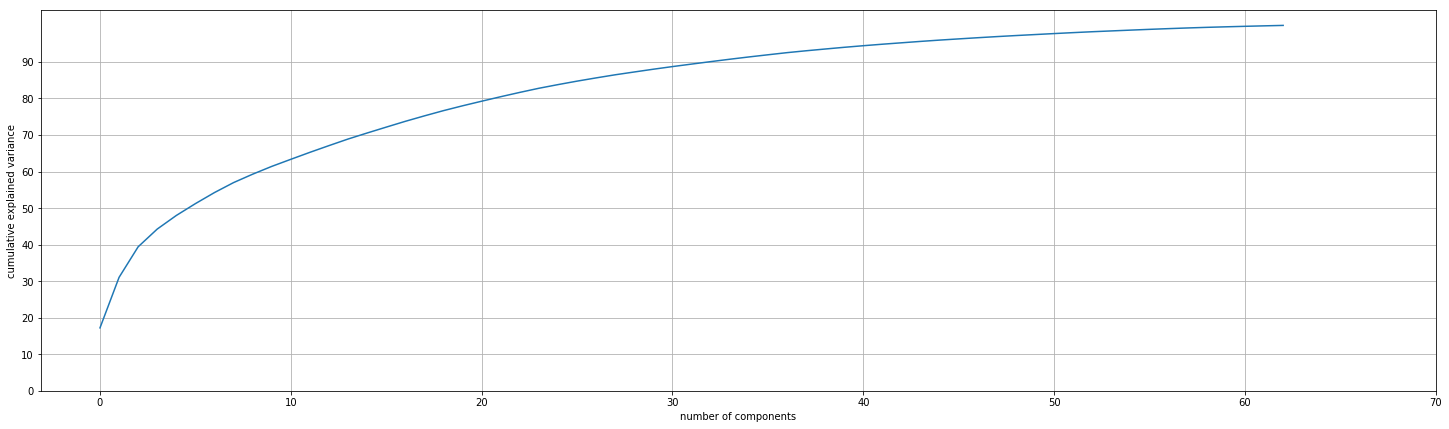

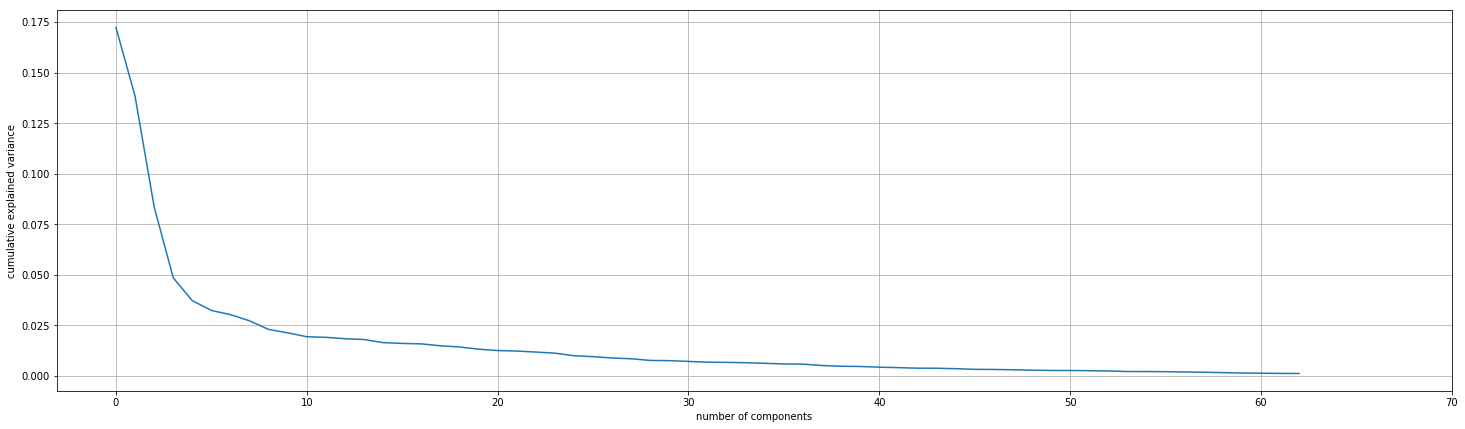

In [31]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_full)
explain_variance(pca_full)

In [32]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30, X_pca_30 = do_pca(30, imputed_df)

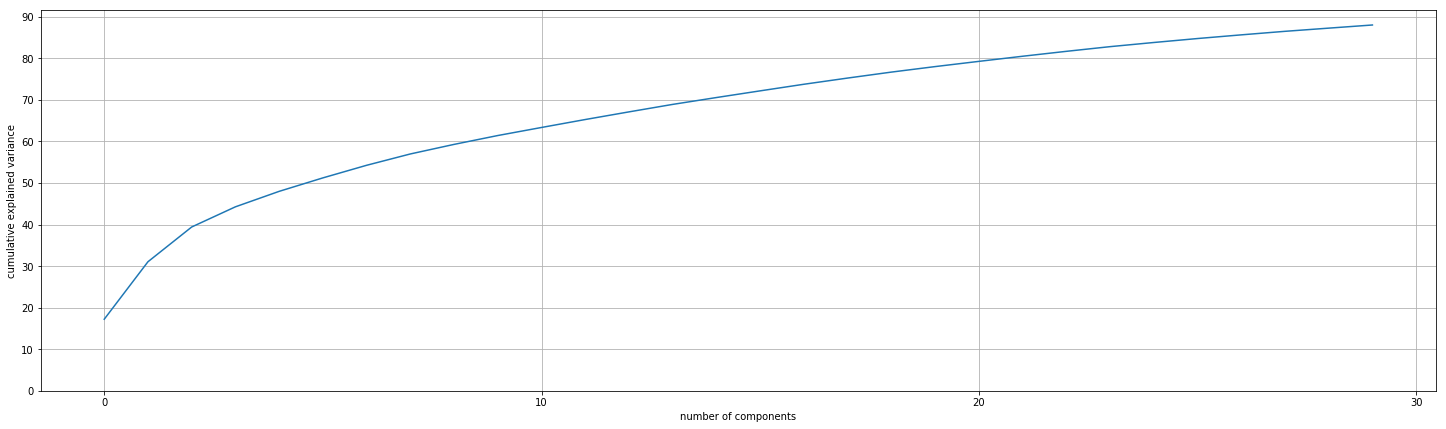

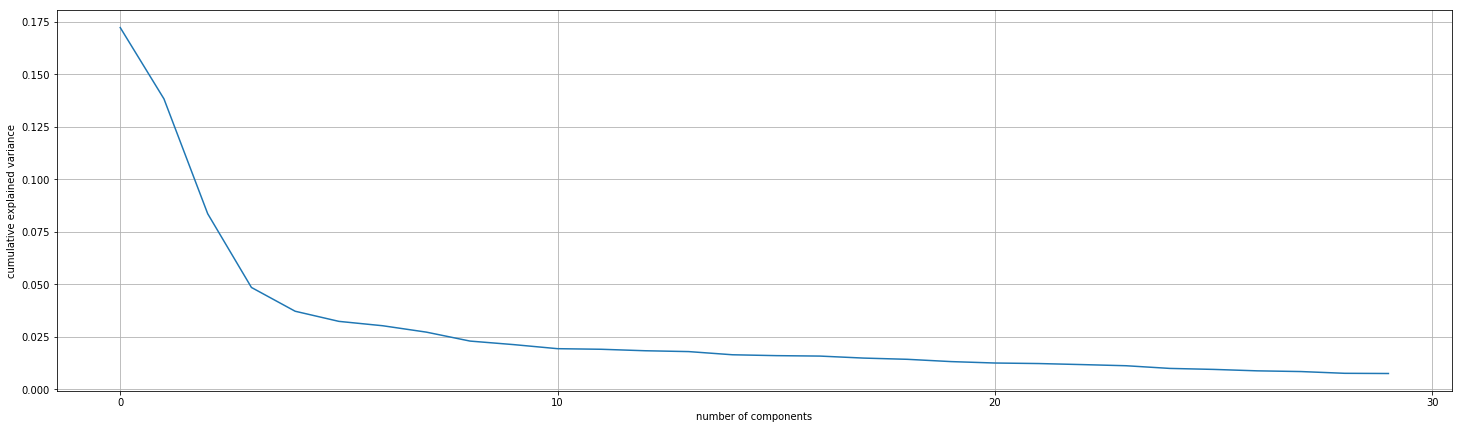

In [33]:
scree_plot(pca_30)
explain_variance(pca_30)

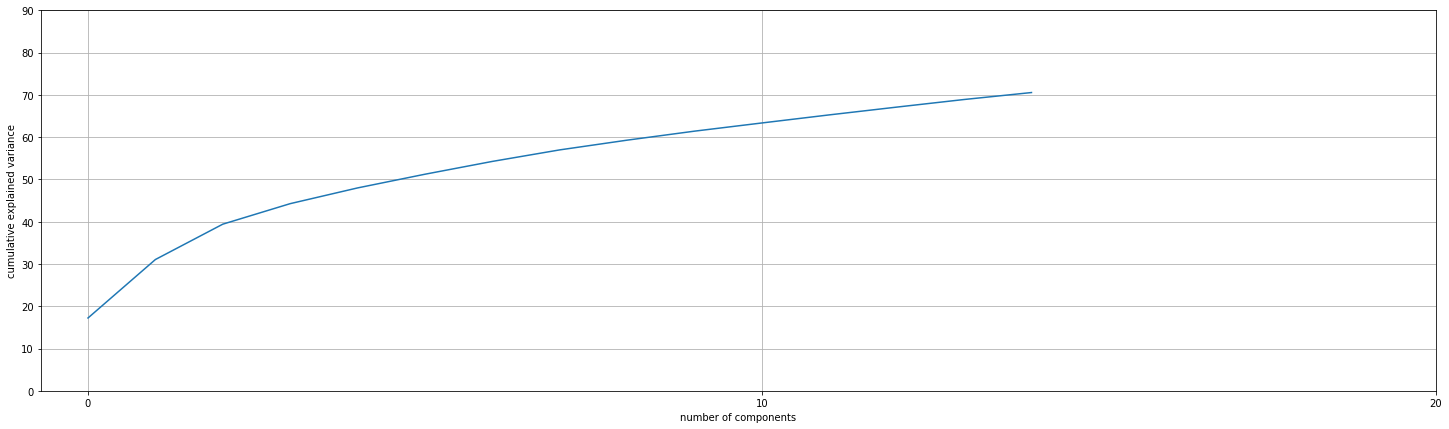

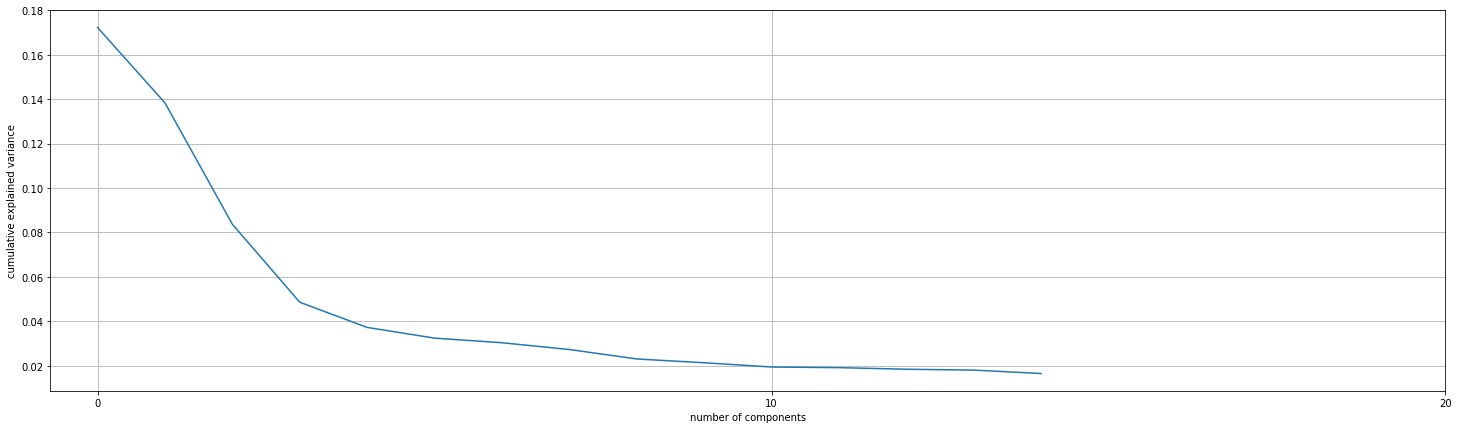

In [34]:
pca_15, X_pca_15 = do_pca(15, imputed_df)
scree_plot(pca_15)
explain_variance(pca_15)

In [35]:
from IPython.core.display import HTML
display(HTML(pca_results(imputed_df, pca_15).T.to_html()))


### Discussion 2.2: Perform Dimensionality Reduction

The way i see the accumelated retained information after 50 principle component start to vanish, as at 50 it explains almost 95% of the entire features.

im going to use 20 compenents as it explains a a almost 70% of the variability in the dataset which i beleive is good number and it retains high ratio of information. i choose not to follow the elbow role which is around the 5th pc as it explains 50% of the variability in the dataset which is quite low. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
def pc_weight_per_feature(pca, dataset_df, what=0):
    indecies = [f'{i}' for i in range(1, 16)]
    df = pd.DataFrame(pca.components_, columns=dataset_df.columns, index=indecies)
    df.index.name = 'level'
    if what == 0: 
        return df 
    else:
        s = df.iloc[what-1].sort_values(ascending=False)
        return s

def convert_to_ordered_dict(d):
    from collections import OrderedDict
    return OrderedDict(sorted(d.items(), key=lambda x:x[1], reverse=True))

In [41]:
pc_weights = pc_weight_per_feature(pca_15, imputed_df)
pc_weights.head(3)

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
level                                                           
1                 -0.149597          -0.223834       0.167107   
2                  0.251578           0.046578      -0.222272   
3                  0.071464           0.169625      -0.099364   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
level                                                            
1             -0.136678        0.085466               0.098488   
2              0.218785       -0.203371              -0.220076   
3              0.095176       -0.191224              -0.088811   

       FINANZ_HAUSBAUER  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  \
level                                                            
1              0.144330    0.038154       -0.039453   0.054470   
2              0.130296   -0.051936        0.167272  -0.089376   
3             -0.060129   -0.020870        0.115834   0.292521   

                     ...                  ORTSGR_KLS9  RELAT_AB  \
level                ...                                          
1                    ...                     0.191112  0.128863   
2                    ...                     0.113803  0.079961   
3                    ...                     0.042772  0.026983   

       GREEN_AVANTGARDE_1  SOHO_KZ_1.0  CAMEO_INTL_2015_WEALTH  \
level                                                            
1               -0.105459    -0.001941                0.197216   
2               -0.029748    -0.002442                0.096156   
3                0.055136     0.000723                0.018822   

       CAMEO_INTL_2015_LIFE_STAGE  PRAEGENDE_JUGENDJAHRE_PERIOD  \
level                                                             
1                       -0.126604                      0.115370   
2                       -0.017361                     -0.239085   
3                       -0.008183                     -0.099369   

       PRAEGENDE_JUGENDJAHRE_DIRECTION_EW  PRAEGENDE_JUGENDJAHRE_DIRECTION_W  \
level                                                                          
1                                0.011808                          -0.025747   
2                                0.026190                          -0.039677   
3                               -0.007938                          -0.000375   

       PRAEGENDE_JUGENDJAHRE_DIRECTION_x  
level                                     
1                              -0.000464  
2                               0.063804  
3                               0.018580  

[3 rows x 63 columns]

In [42]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pc1_weights = pc_weight_per_feature(pca_15, imputed_df, 1)
pc1_top_5 = pc1_weights.keys()[1:6].tolist()
pc1_lower_5 = pc1_weights.keys()[-6:-1].tolist()

#convert_to_ordered_dict(pc_weights)
print(pc1_weights)


PLZ8_ANTG3                            0.217963
PLZ8_ANTG4                            0.211148
CAMEO_INTL_2015_WEALTH                0.197216
HH_EINKOMMEN_SCORE                    0.191853
ORTSGR_KLS9                           0.191112
EWDICHTE                              0.188461
FINANZ_SPARER                         0.167107
KBA05_ANTG4                           0.146077
PLZ8_ANTG2                            0.145802
FINANZ_HAUSBAUER                      0.144330
ARBEIT                                0.138744
SEMIO_PFLICHT                         0.136181
SEMIO_REL                             0.133493
KBA05_ANTG3                           0.131432
RELAT_AB                              0.128863
ANZ_HAUSHALTE_AKTIV                   0.127729
SEMIO_TRADV                           0.122523
PRAEGENDE_JUGENDJAHRE_PERIOD          0.115370
SEMIO_RAT                             0.111607
SEMIO_MAT                             0.099501
FINANZ_UNAUFFAELLIGER                 0.098488
SEMIO_FAM    

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc2_weights = pc_weight_per_feature(pca_15, imputed_df, 2)
pc2_top_5 = pc2_weights.keys()[1:6].tolist()
pc2_lower_5 = pc2_weights.keys()[-6:-1].tolist()
#convert_to_ordered_dict(pc_weights)
pc2_weights


ALTERSKATEGORIE_GROB                  0.251578
FINANZ_VORSORGER                      0.218785
SEMIO_ERL                             0.218674
SEMIO_LUST                            0.175079
RETOURTYP_BK_S                        0.167272
FINANZ_HAUSBAUER                      0.130296
PLZ8_ANTG3                            0.120907
PLZ8_ANTG4                            0.116717
EWDICHTE                              0.114183
ORTSGR_KLS9                           0.113803
SEMIO_KRIT                            0.108729
SEMIO_KAEM                            0.100295
CAMEO_INTL_2015_WEALTH                0.096156
KBA05_ANTG4                           0.090804
ARBEIT                                0.083794
PLZ8_ANTG2                            0.080208
RELAT_AB                              0.079961
ANZ_HAUSHALTE_AKTIV                   0.077773
HH_EINKOMMEN_SCORE                    0.069901
PRAEGENDE_JUGENDJAHRE_DIRECTION_x     0.063804
KBA05_ANTG3                           0.060796
SEMIO_DOM    

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pc3_weights = pc_weight_per_feature(pca_15, imputed_df, 3)
pc3_top_5 = pc3_weights.keys()[1:6].tolist()
pc3_lower_5 = pc3_weights.keys()[-6:-1].tolist()
#convert_to_ordered_dict(pc_weights)
pc3_weights


SEMIO_VERT                           0.380298
SEMIO_SOZ                            0.292521
SEMIO_FAM                            0.282879
SEMIO_KULT                           0.260834
FINANZ_MINIMALIST                    0.169625
RETOURTYP_BK_S                       0.115834
SEMIO_REL                            0.100936
FINANZ_VORSORGER                     0.095176
ALTERSKATEGORIE_GROB                 0.071464
SEMIO_LUST                           0.069736
SEMIO_MAT                            0.066791
GREEN_AVANTGARDE_1                   0.055136
EWDICHTE                             0.043109
ORTSGR_KLS9                          0.042772
PLZ8_ANTG4                           0.041853
PLZ8_ANTG3                           0.039957
WOHNDAUER_2008                       0.039483
W_KEIT_KIND_HH                       0.028842
ARBEIT                               0.027769
RELAT_AB                             0.026983
KBA05_ANTG4                          0.026846
PLZ8_ANTG2                        

In [45]:
pc30_weights = pc_weight_per_feature(pca_15, imputed_df, 15)
pc3_top_5 = pc30_weights.keys()[1:6].tolist()
pc3_lower_5 = pc30_weights.keys()[-6:-1].tolist()
#convert_to_ordered_dict(pc_weights)
print(pc3_weights)


print('-'*22, 'TOP 5', '-'*22)
print(f'pc1: {pc1_top_5}')
print(f'pc2: {pc2_top_5}')
print(f'pc3: {pc3_top_5}')
print('-'*22, 'LOW 5', '-'*22)
print(f'pc1: {pc1_lower_5}')
print(f'pc2: {pc2_lower_5}')
print(f'pc3: {pc3_lower_5}')

SEMIO_VERT                           0.380298
SEMIO_SOZ                            0.292521
SEMIO_FAM                            0.282879
SEMIO_KULT                           0.260834
FINANZ_MINIMALIST                    0.169625
RETOURTYP_BK_S                       0.115834
SEMIO_REL                            0.100936
FINANZ_VORSORGER                     0.095176
ALTERSKATEGORIE_GROB                 0.071464
SEMIO_LUST                           0.069736
SEMIO_MAT                            0.066791
GREEN_AVANTGARDE_1                   0.055136
EWDICHTE                             0.043109
ORTSGR_KLS9                          0.042772
PLZ8_ANTG4                           0.041853
PLZ8_ANTG3                           0.039957
WOHNDAUER_2008                       0.039483
W_KEIT_KIND_HH                       0.028842
ARBEIT                               0.027769
RELAT_AB                             0.026983
KBA05_ANTG4                          0.026846
PLZ8_ANTG2                        

### Discussion 2.3: Interpret Principal Components

based on the privious results for the first 3 pc's we could say 

1. for every pc level their is different features that contributes more than other in creating the biggest variance or explains the most variance. the variance is not affected by the sign as the sign represents direction not magnitude. so the main contributers are the top 5 features and the lower 5 features.  

2. top 5 and lower 5 is highly correlated as they have been loaded in the SAME Principal Component (Eigenvector). which means that an increase in one the remaining ones tend to increase as well.

    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
def get_kmeans_score(data, center):

    kmeans = KMeans(n_clusters=center, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return model, score



In [47]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores = []
models = []

centers = list(range(1,27, 3))

for center in centers:
    model, score = get_kmeans_score(X_pca_15, center)
    labels = model.predict(X_pca_15)
    scores.append(score)
    models.append(model)

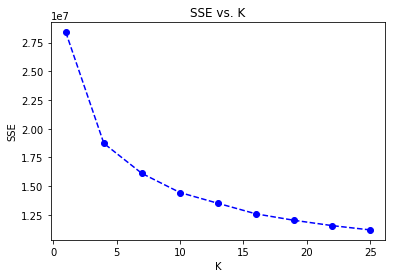

In [48]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [50]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=15)
model = kmeans.fit(X_pca_15)
predictions = model.predict(X_pca_15)


### Discussion 3.1: Apply Clustering to General Population

from the above plot, its not clear where is the cut-off point as the SSE continues to minimize smoothly, but we can see also that around 15 the SSE decrease almost negligible, which lead me to choose 15 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [51]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
print(customers.shape)
customers.head(3)

(191652, 85)


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  

[3 rows x 85 columns]

In [52]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers_df =clean_data(customers)
print(clean_customers_df.shape)
clean_customers_df.head(3)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


missing values for [PRAEGENDE_JUGENDJAHRE_PERIOD]:  314
missing values for [PRAEGENDE_JUGENDJAHRE_DIRECTION]:  314
(116609, 63)


ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                   4.0                  5              1                 5   
1                   4.0                  5              1                 5   
2                   3.0                  3              1                 4   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0               1                      2                 2         1.0   
1               1                      4                 4         2.0   
2               4                      5                 2         3.0   

   RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0             5.0          6                ...                          2.0   
1             5.0          2                ...                          5.0   
2             5.0          4                ...                          5.0   

   RELAT_AB  GREEN_AVANTGARDE_1  SOHO_KZ_1.0  CAMEO_INTL_2015_WEALTH  \
0       1.0                   1            0                       1   
1       3.0                   1            0                       3   
2       1.0                   0            0                       4   

   CAMEO_INTL_2015_LIFE_STAGE  PRAEGENDE_JUGENDJAHRE_PERIOD  \
0                           3                          50.0   
1                           4                          50.0   
2                           1                          70.0   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_EW  PRAEGENDE_JUGENDJAHRE_DIRECTION_W  \
0                                   1                                  0   
1                                   1                                  0   
2                                   1                                  0   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_x  
0                                  0  
1                                  0  
2                                  0  

[3 rows x 63 columns]

In [54]:
clean_customers_df[clean_customers_df.columns].shape

#remove NaNs
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
df = pd.DataFrame(fill_NaN.fit_transform(clean_customers_df))
df.columns = clean_customers_df.columns
df.index = clean_customers_df.index
df.head()


df[df.columns] = normalizer.transform(df[df.columns].as_matrix())

#transform the customers data using pca object
X_customer_pca = pca_15.transform(df)
#predict clustering using the kmeans object
predict_customers = model.predict(X_customer_pca)

print(df.shape)
df.head()

(116609, 63)


ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0              1.162959           1.433016      -1.132295          1.107486   
1              1.162959           1.433016      -1.132295          1.107486   
2              0.193101          -0.038042      -1.132295          0.387398   
3              0.193101           1.433016      -1.132295          1.107486   
4              1.162959           1.433016      -1.132295          1.107486   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0       -1.213905              -0.406161         -0.869497   -1.587315   
1       -1.213905               1.049674          0.591320   -0.267127   
2        0.849536               1.777591         -0.869497    1.053060   
3       -1.213905              -0.406161         -0.139088    1.053060   
4       -1.213905              -1.134078         -0.869497   -0.267127   

   RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0        1.079962   0.903408                ...                    -1.480262   
1        1.079962  -1.143461                ...                    -0.173454   
2        1.079962  -0.120026                ...                    -0.173454   
3       -0.292609   0.903408                ...                     0.697751   
4        1.079962  -0.120026                ...                    -1.044659   

   RELAT_AB  GREEN_AVANTGARDE_1  SOHO_KZ_1.0  CAMEO_INTL_2015_WEALTH  \
0 -1.566467            1.821475    -0.092409               -1.604078   
1 -0.085540            1.821475    -0.092409               -0.231589   
2 -1.566467           -0.549006    -0.092409                0.454655   
3  1.395386            1.821475    -0.092409               -0.231589   
4 -0.826003            1.821475    -0.092409               -0.917834   

   CAMEO_INTL_2015_LIFE_STAGE  PRAEGENDE_JUGENDJAHRE_PERIOD  \
0                    0.083614                     -1.388253   
1                    0.749749                     -1.388253   
2                   -1.248658                     -0.150397   
3                    0.749749                     -1.388253   
4                    0.083614                     -1.388253   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_EW  PRAEGENDE_JUGENDJAHRE_DIRECTION_W  \
0                            0.567629                          -0.484142   
1                            0.567629                          -0.484142   
2                            0.567629                          -0.484142   
3                            0.567629                          -0.484142   
4                            0.567629                          -0.484142   

   PRAEGENDE_JUGENDJAHRE_DIRECTION_x  
0                          -0.099197  
1                          -0.099197  
2                          -0.099197  
3                          -0.099197  
4                          -0.099197  

[5 rows x 63 columns]

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

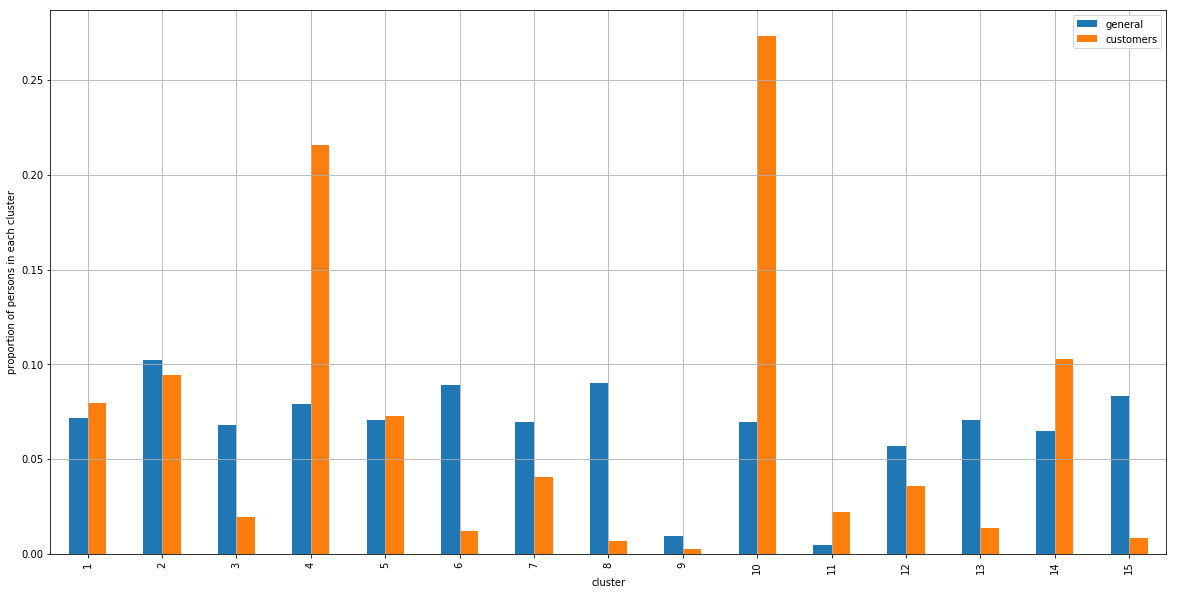

In [56]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_prop = []
customers_prop = []
x = [i+1 for i in range(15)]
for i in range(15):
    general_prop.append((predictions == i).sum()/len(predictions))
    customers_prop.append((predict_customers == i).sum()/len(predict_customers))


    
fig, ax = plt.subplots()
df_general = pd.DataFrame({'cluster' : x, 'general' : general_prop, 'customers':customers_prop})
df_general.plot(x='cluster', y = ['general', 'customers'], kind='bar', figsize=(20,10), ax=ax)
plt.ylabel('proportion of persons in each cluster')
ax.grid()
plt.show()


In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# the 10th cluster is overrepresented

data1_10 = normalizer.inverse_transform(pca_15.inverse_transform(X_customer_pca[np.where(predict_customers==9)])).round()

df = pd.DataFrame(data=data1_10,
          index=np.array(range(0, data1_10.shape[0])),
          columns=df.columns)
df.head(20)


ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                    4.0                5.0            1.0               5.0   
1                    3.0                5.0            1.0               4.0   
2                    4.0                5.0            1.0               5.0   
3                    3.0                5.0            2.0               4.0   
4                    3.0                5.0            2.0               4.0   
5                    3.0                5.0            1.0               5.0   
6                    3.0                5.0            1.0               5.0   
7                    3.0                4.0            3.0               3.0   
8                    3.0                4.0            2.0               4.0   
9                    4.0                5.0            1.0               4.0   
10                   3.0                5.0            2.0               4.0   
11                   3.0                5.0            1.0               5.0   
12                   4.0                4.0            3.0               3.0   
13                   4.0                6.0            0.0               5.0   
14                   3.0                4.0            2.0               4.0   
15                   4.0                5.0            1.0               5.0   
16                   3.0                5.0            2.0               4.0   
17                   3.0                5.0            0.0               5.0   
18                   3.0                5.0            1.0               5.0   
19                   4.0                5.0            1.0               5.0   

    FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0              0.0                    2.0               3.0         1.0   
1              1.0                    2.0               2.0         3.0   
2              0.0                    2.0               3.0         1.0   
3              2.0                    3.0               1.0         3.0   
4              1.0                    3.0               2.0         1.0   
5              1.0                    2.0               2.0         1.0   
6              1.0                    2.0               2.0         1.0   
7              3.0                    4.0               1.0         2.0   
8              1.0                    2.0               3.0         1.0   
9              1.0                    2.0               1.0         1.0   
10             2.0                    2.0               1.0         3.0   
11             1.0                    2.0               1.0         3.0   
12             2.0                    4.0               2.0         1.0   
13            -0.0                    1.0               2.0         1.0   
14             2.0                    3.0               2.0         3.0   
15             1.0                    1.0               2.0         2.0   
16             1.0                    2.0               2.0         2.0   
17             0.0                    2.0               2.0         1.0   
18             0.0                    1.0               3.0         3.0   
19             1.0                    2.0               1.0         2.0   

    RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0              4.0        6.0                ...                          3.0   
1              4.0        5.0                ...                          6.0   
2              4.0        6.0                ...                          5.0   
3              3.0        6.0                ...                          6.0   
4              3.0        6.0                ...                          4.0   
5              4.0        5.0                ...                          5.0   
6              4.0        6.0                ...                          4.0   
7              2.0        6.0                ...                          5.0   
8              4.0

In [60]:
#general part

data_2_10 = normalizer.inverse_transform(pca_15.inverse_transform(X_pca_15[np.where(predictions==9)])).round()

df = pd.DataFrame(data=data_2_10,
          index=np.array(range(0, data_2_10.shape[0])),
          columns=df.columns)
df.head(20)

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                    3.0                4.0            3.0               3.0   
1                    3.0                4.0            2.0               4.0   
2                    3.0                4.0            3.0               2.0   
3                    3.0                4.0            2.0               4.0   
4                    4.0                5.0            2.0               4.0   
5                    3.0                5.0            2.0               4.0   
6                    3.0                6.0            2.0               3.0   
7                    3.0                4.0            2.0               4.0   
8                    3.0                4.0            2.0               4.0   
9                    4.0                5.0            1.0               5.0   
10                   4.0                5.0            1.0               5.0   
11                   3.0                5.0            2.0               4.0   
12                   3.0                5.0            2.0               4.0   
13                   3.0                4.0            3.0               3.0   
14                   3.0                5.0            2.0               4.0   
15                   2.0                4.0            3.0               3.0   
16                   3.0                5.0            2.0               4.0   
17                   2.0                4.0            4.0               2.0   
18                   4.0                5.0            1.0               5.0   
19                   3.0                5.0            3.0               3.0   

    FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0              2.0                    3.0               2.0         3.0   
1              1.0                    2.0               2.0         3.0   
2              2.0                    3.0               1.0         3.0   
3              2.0                    3.0               2.0         1.0   
4              2.0                    3.0               1.0         2.0   
5              2.0                    2.0               2.0         3.0   
6              2.0                    2.0              -0.0         3.0   
7              2.0                    2.0               2.0         3.0   
8              1.0                    2.0               3.0         3.0   
9              1.0                    2.0               3.0         1.0   
10             1.0                    2.0               3.0         1.0   
11             2.0                    3.0               1.0         3.0   
12             2.0                    3.0               1.0         3.0   
13             3.0                    3.0               1.0         3.0   
14             2.0                    3.0               1.0         3.0   
15             3.0                    3.0               1.0         2.0   
16             1.0                    2.0               2.0         2.0   
17             3.0                    4.0               1.0         2.0   
18             1.0                    2.0               3.0         1.0   
19             3.0                    3.0               1.0         3.0   

    RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0              3.0        5.0                ...                          5.0   
1              4.0        5.0                ...                          6.0   
2              3.0        5.0                ...                          8.0   
3              3.0        4.0                ...                          4.0   
4              3.0        5.0                ...                          6.0   
5              4.0        6.0                ...                          7.0   
6              4.0        5.0                ...                          2.0   
7              4.0        5.0                ...                          4.0   
8              4.0

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster 8

data_1_8 = normalizer.inverse_transform(pca_15.inverse_transform(X_customer_pca[np.where(predict_customers==7)])).round()

df = pd.DataFrame(data=data_1_8,
          index=np.array(range(0, data_1_8.shape[0])),
          columns=df.columns)
df.head(20)



ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                    2.0                3.0            2.0               5.0   
1                    1.0                1.0            5.0               2.0   
2                    2.0                1.0            4.0               2.0   
3                    2.0                1.0            4.0               2.0   
4                    1.0                1.0            4.0               2.0   
5                    1.0                1.0            5.0               2.0   
6                    2.0                2.0            3.0               3.0   
7                    2.0                1.0            3.0               4.0   
8                    1.0                1.0            5.0               1.0   
9                    1.0                1.0            5.0               1.0   
10                   2.0                2.0            3.0               3.0   
11                   1.0                1.0            5.0               2.0   
12                   1.0                0.0            5.0               1.0   
13                   2.0                2.0            4.0               2.0   
14                   1.0                2.0            4.0               2.0   
15                   2.0                2.0            3.0               4.0   
16                   2.0                3.0            2.0               4.0   
17                   1.0                0.0            6.0               1.0   
18                   2.0                2.0            3.0               3.0   
19                   1.0                1.0            5.0               2.0   

    FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0              2.0                    1.0               4.0         3.0   
1              4.0                    4.0               4.0         3.0   
2              4.0                    4.0               4.0         3.0   
3              4.0                    4.0               4.0         1.0   
4              3.0                    4.0               4.0         3.0   
5              4.0                    4.0               5.0         2.0   
6              3.0                    2.0               4.0         2.0   
7              2.0                    2.0               5.0         2.0   
8              4.0                    4.0               4.0         3.0   
9              5.0                    4.0               4.0         2.0   
10             3.0                    3.0               4.0         2.0   
11             4.0                    4.0               4.0         3.0   
12             5.0                    5.0               4.0         2.0   
13             3.0                    4.0               4.0         2.0   
14             4.0                    4.0               3.0         3.0   
15             2.0                    2.0               4.0         2.0   
16             2.0                    2.0               4.0         2.0   
17             5.0                    5.0               4.0         2.0   
18             3.0                    3.0               3.0         2.0   
19             5.0                    4.0               4.0         3.0   

    RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0              6.0        3.0                ...                          8.0   
1              2.0        3.0                ...                          7.0   
2              3.0        3.0                ...                          6.0   
3              2.0        2.0                ...                          8.0   
4              3.0        3.0                ...                          9.0   
5              2.0        3.0                ...                          8.0   
6              3.0        3.0                ...                          8.0   
7              4.0        3.0                ...                          8.0   
8              2.0

In [62]:
#general 

data_2_8 = normalizer.inverse_transform(pca_15.inverse_transform(X_pca_15[np.where(predictions==7)])).round()

df = pd.DataFrame(data=data_2_8,
          index=np.array(range(0, data_2_8.shape[0])),
          columns=df.columns)
df.head(20)

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0                    1.0                1.0            5.0               2.0   
1                    2.0                1.0            4.0               2.0   
2                    2.0                3.0            2.0               4.0   
3                    2.0                1.0            5.0               2.0   
4                    1.0                1.0            5.0               2.0   
5                    1.0                0.0            5.0               1.0   
6                    2.0                1.0            4.0               2.0   
7                    1.0                1.0            5.0               2.0   
8                    1.0                2.0            5.0               2.0   
9                    2.0                1.0            5.0               2.0   
10                   2.0                2.0            3.0               4.0   
11                   1.0                1.0            5.0               2.0   
12                   1.0                1.0            4.0               2.0   
13                   1.0                1.0            5.0               2.0   
14                   2.0                2.0            3.0               3.0   
15                   2.0                2.0            4.0               2.0   
16                   1.0                1.0            5.0               2.0   
17                   1.0                1.0            5.0               1.0   
18                   1.0                1.0            5.0               2.0   
19                   1.0                1.0            5.0               2.0   

    FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
0              5.0                    4.0               4.0         3.0   
1              4.0                    4.0               4.0         1.0   
2              2.0                    2.0               4.0         2.0   
3              4.0                    4.0               4.0         3.0   
4              4.0                    4.0               4.0         3.0   
5              5.0                    5.0               4.0         3.0   
6              4.0                    4.0               4.0         2.0   
7              4.0                    4.0               4.0         2.0   
8              5.0                    4.0               3.0         2.0   
9              4.0                    4.0               4.0         2.0   
10             3.0                    2.0               4.0         2.0   
11             4.0                    4.0               4.0         2.0   
12             4.0                    4.0               4.0         3.0   
13             5.0                    3.0               4.0         3.0   
14             3.0                    2.0               4.0         2.0   
15             4.0                    4.0               3.0         2.0   
16             5.0                    5.0               5.0         2.0   
17             5.0                    5.0               4.0         3.0   
18             5.0                    4.0               5.0         2.0   
19             5.0                    4.0               4.0         3.0   

    RETOURTYP_BK_S  SEMIO_SOZ                ...                  ORTSGR_KLS9  \
0              2.0        4.0                ...                          4.0   
1              3.0        3.0                ...                          9.0   
2              4.0        2.0                ...                          8.0   
3              3.0        4.0                ...                          9.0   
4              3.0        4.0                ...                          8.0   
5              2.0        4.0                ...                          9.0   
6              3.0        3.0                ...                          8.0   
7              2.0        3.0                ...                          8.0   
8              2.0

In [63]:
cust_df = pd.DataFrame(X_customer_pca, columns=np.arange(1, 16))
cust_df['cluster'] = predict_customers
cust_df.describe()

1              2              3              4  \
count  116609.000000  116609.000000  116609.000000  116609.000000   
mean       -2.562325       1.045009       1.350877       0.778240   
std         2.593779       2.185210       2.046077       1.864759   
min       -10.460801      -7.508819      -4.508346      -5.975267   
25%        -4.532047      -0.350657      -0.724747      -0.631400   
50%        -3.216142       0.916252       1.988773       0.774432   
75%        -0.992660       2.406255       2.988525       2.174784   
max        10.399194      11.400199       5.914888       8.610200   

                   5              6              7              8  \
count  116609.000000  116609.000000  116609.000000  116609.000000   
mean       -0.015058       0.086964      -0.322565       0.040910   
std         1.518706       1.321063       1.235363       1.351884   
min        -6.272879      -3.415393      -4.054628      -5.602639   
25%        -1.093821      -0.701477      -1.184217      -0.912235   
50%        -0.152822       0.002271      -0.551586       0.090821   
75%         0.952971       0.717549       0.218909       1.007417   
max         7.609500      30.350037       4.515902       6.080259   

                   9             10             11             12  \
count  116609.000000  116609.000000  116609.000000  116609.000000   
mean        0.032596       0.489332       0.066128       0.110077   
std         1.165895       1.051161       1.786718       1.430394   
min        -6.374754      -6.329422      -3.066150      -5.563806   
25%        -0.732486      -0.198683      -0.620663      -0.642537   
50%         0.003004       0.436164      -0.143934      -0.093939   
75%         0.784739       1.138537       0.325180       0.587685   
max         5.342037      11.786643      57.979978      40.802583   

                  13             14             15        cluster  
count  116609.000000  116609.000000  116609.000000  116609.000000  
mean       -0.239823      -0.048712      -0.104548       6.134132  
std         1.048925       0.977259       0.734685       4.187678  
min        -8.791308      -7.766257      -4.036512       0.000000  
25%        -0.954211      -0.671084      -0.544686       3.000000  
50%        -0.248549      -0.039415      -0.127813       6.000000  
75%         0.464607       0.569537       0.277474       9.000000  
max         7.810122       8.522459       9.342589      14.000000

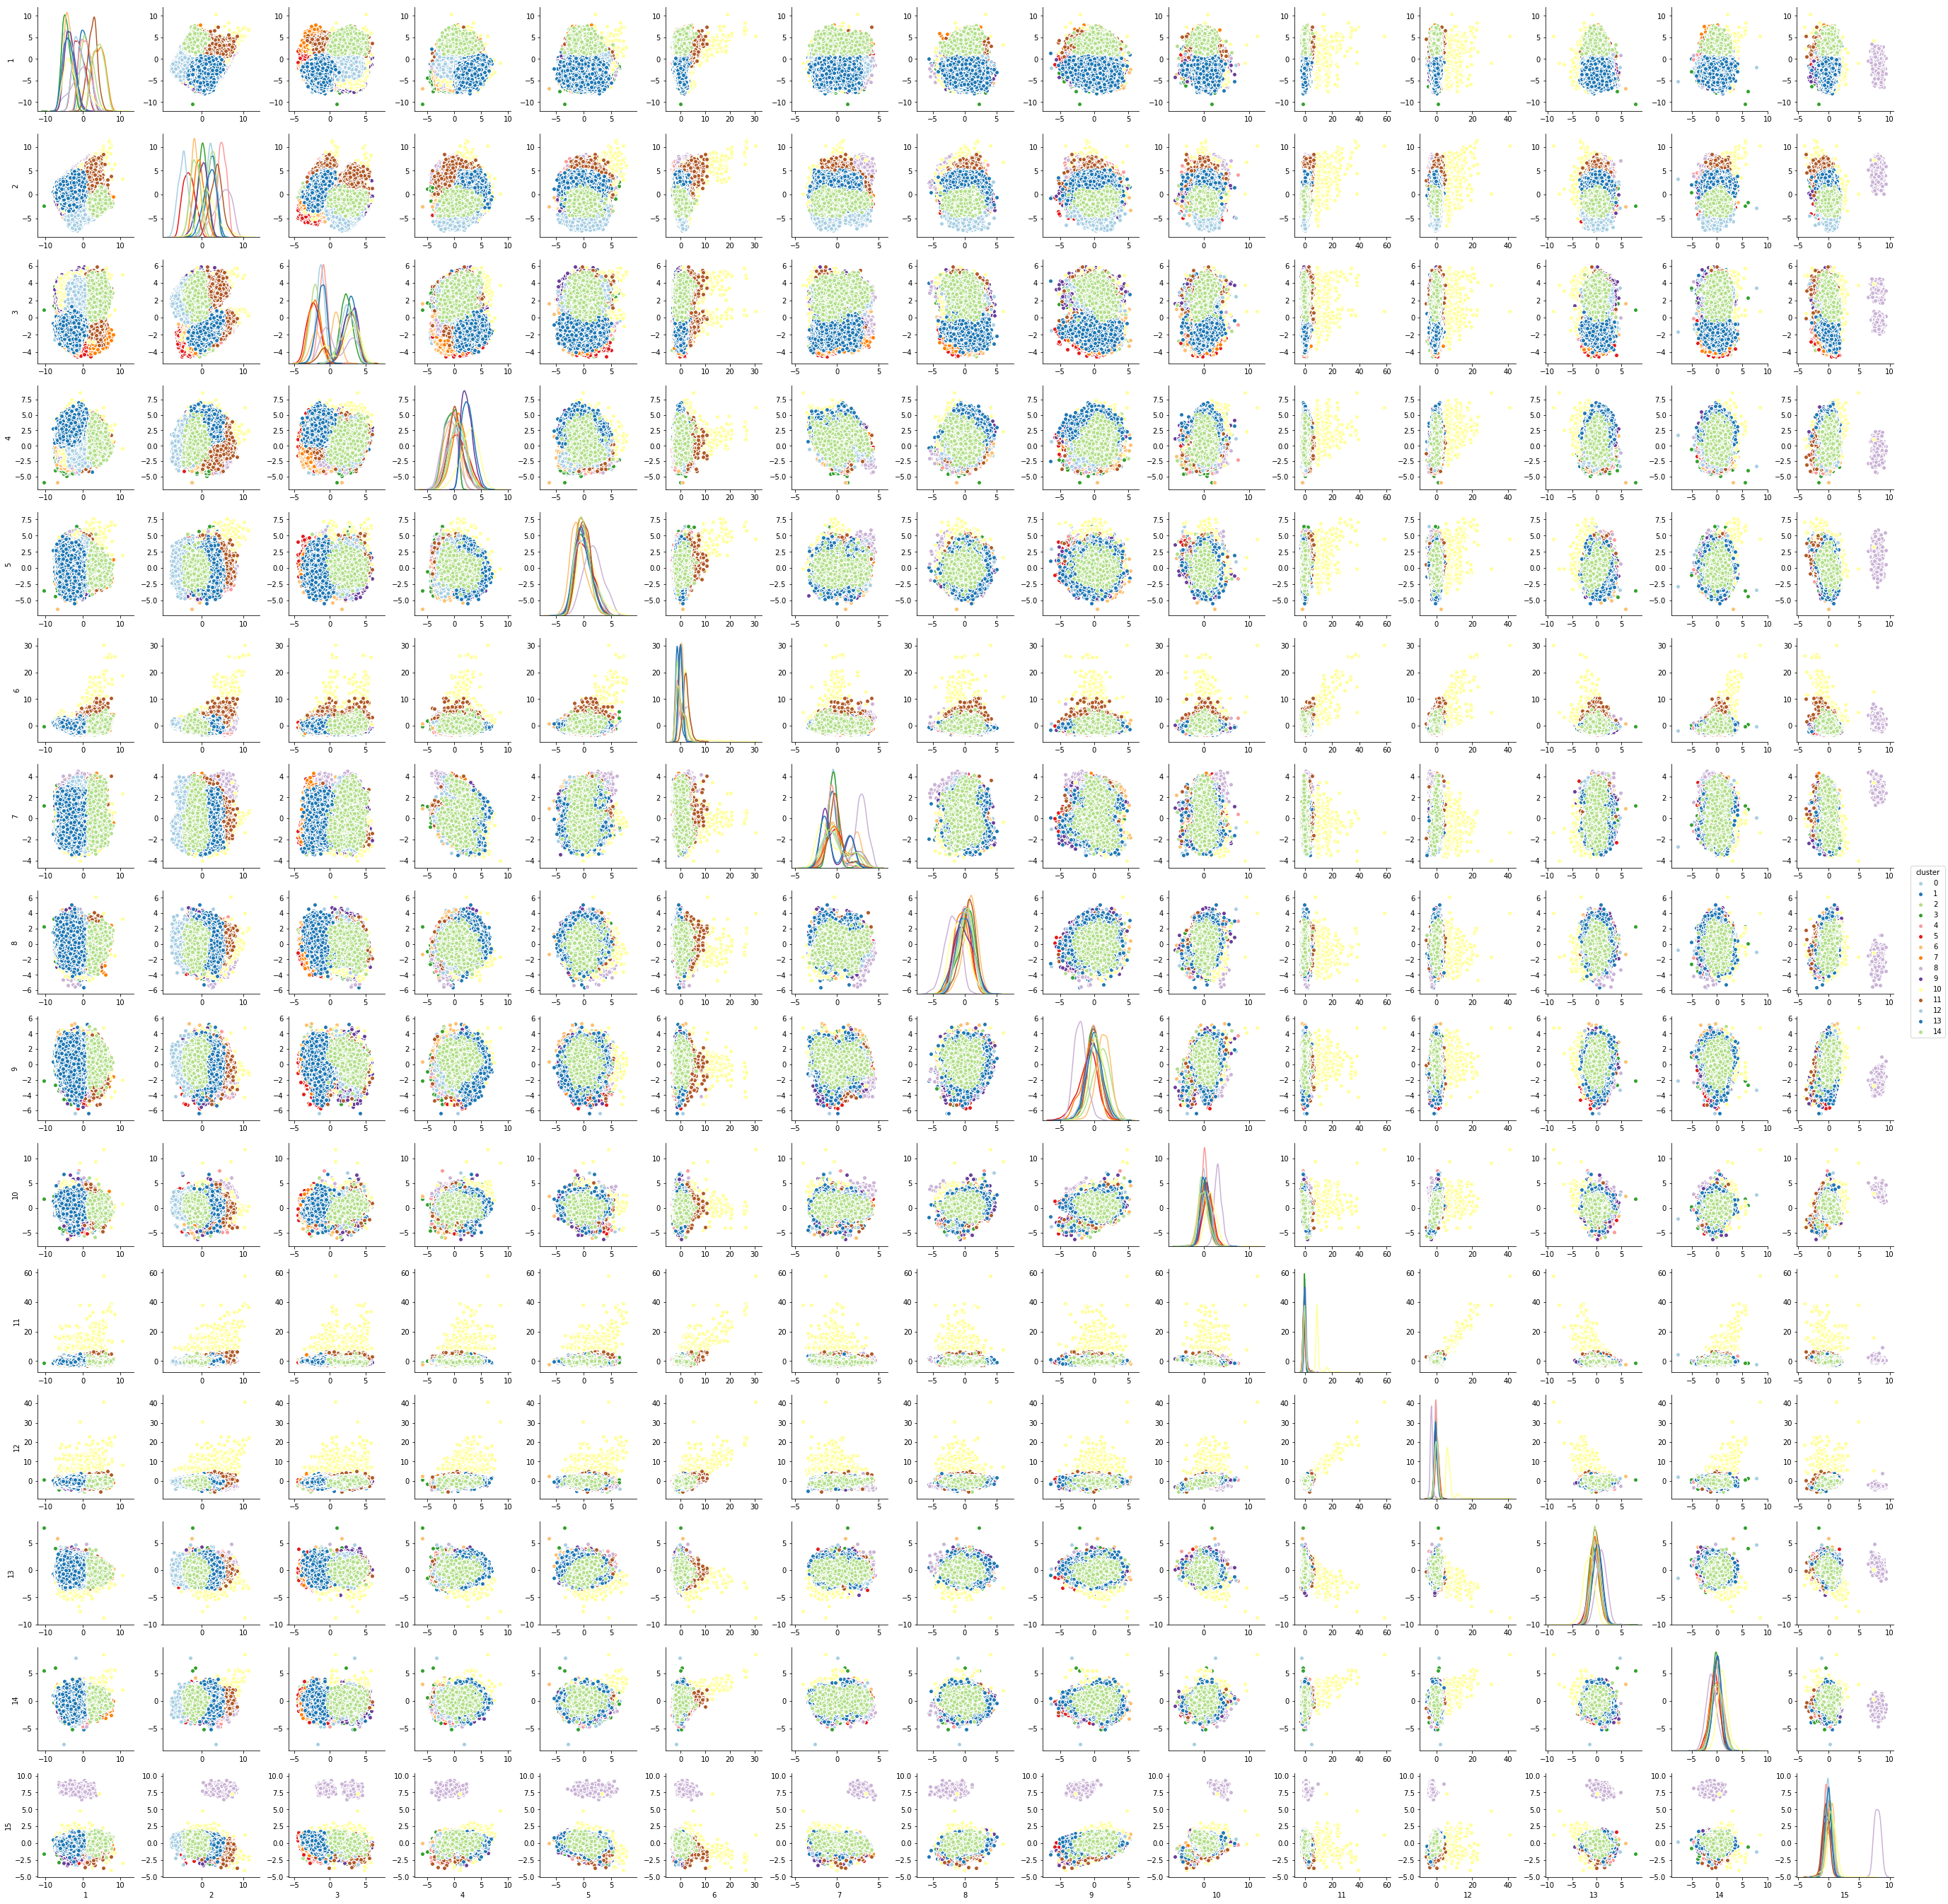

In [64]:
g = sns.pairplot(cust_df,
                 vars = np.arange(1, 16), 
                 diag_kind = 'kde',
                 hue="cluster",
                 palette="Paired");

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


cluster 4, 10 are overrepresented in the customer data compared to the general population, while clusters 8, 15 is the clusters that is being underpresented based on customer data.

i think we could safely assume the the people in cluster 4, 9 are the most interesting people from customer base prespective, as for the features role extraction form PCA_15 that Personality typology, affectes positively, on the other hand it could be that the traget customers are likely to be the ones that belongs to those clusters from the general population

also what we could see from the pairplot that the seperation of clustes it clear up to the 4th component, and more uniformally distributed.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.